In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_recall_curve

test_df = pd.read_csv("../data/test.tsv", sep="\t", encoding = "utf-8", header=None)

test_df.columns = ['text', 'emotions', 'id']

test_df['emotions'] = list(map(lambda s : list(map(int, s.split(','))), test_df['emotions']))

def emotions_to_ekman(df):
    # anger disgust fear joy sadness surprise neutral
    ekman = [3, 3, 0, 0, 3, 3, 5, 5, 3, 4, 0, 1, 4, 3, 2, 3, 4, 3, 3, 2, 3, 3, 5, 3, 4, 4, 5, 6]
    res = []

    for i in df['emotions']:
        tmp = [0, 0, 0, 0, 0, 0, 0]
        for j in i:
            tmp[ekman[j]] = 1
        res.append(tmp)
    tmp_df = pd.DataFrame(res, columns=['angry', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'])
    
    return tmp_df

def emotions_to_categorical(df):
    ems = """
        admiration
        amusement
        anger
        annoyance
        approval
        caring
        confusion
        curiosity
        desire
        disappointment
        disapproval
        disgust
        embarrassment
        excitement
        fear
        gratitude
        grief
        joy
        love
        nervousness
        optimism
        pride
        realization
        relief
        remorse
        sadness
        surprise
        neutral
    """
    res = []

    for i in df['emotions']:
        tmp = [0 for _ in range(28)]
        for j in i:
            tmp[j] = 1
        res.append(tmp)
    tmp_df = pd.DataFrame(res, columns=ems.split())
    
    return tmp_df

test_df = pd.concat([test_df, emotions_to_categorical(test_df)], axis=1)

test_df = test_df.drop(columns=['emotions', 'id'])


load_directory = "bert-base-cased"

num_labels = 28


In [6]:
test_df

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,I’m really sorry about your situation :( Altho...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,It's wonderful because it's awful. At not with.,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Kings fan here, good luck to you guys! Will be...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"I didn't know that, thank you for teaching me ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,They got bored from haunting earth for thousan...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,Thanks. I was diagnosed with BP 1 after the ho...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5423,Well that makes sense.,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5424,Daddy issues [NAME],0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5425,So glad I discovered that subreddit a couple m...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
tokenizer = AutoTokenizer.from_pretrained(load_directory)
model = AutoModelForSequenceClassification.from_pretrained(load_directory, num_labels=num_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ems = """
        admiration
        amusement
        anger
        annoyance
        approval
        caring
        confusion
        curiosity
        desire
        disappointment
        disapproval
        disgust
        embarrassment
        excitement
        fear
        gratitude
        grief
        joy
        love
        nervousness
        optimism
        pride
        realization
        relief
        remorse
        sadness
        surprise
        neutral
    """
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        text = str(self.data.loc[index, 'text'])
        labels = self.data.loc[index, ems.split()].values
        labels = labels.astype('float32')
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        
        return item


MAX_LEN = 512
BATCH_SIZE = 32

test_dataset = EmotionDataset(test_df, tokenizer, MAX_LEN)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



def evaluate_model(model, test_loader, device, emotion_names = ems.split()):
    """
    다중 라벨 분류 모델을 평가하는 통합 함수.
    정확도, F1-점수를 계산하고, 각 라벨에 대한 개별 Precision-Recall 곡선을 그립니다.
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to (device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            probs = torch.sigmoid(logits)
            predictions = (probs > 0.5).int()

            all_predictions.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_predictions = np.vstack(all_predictions)
    all_labels = np.vstack(all_labels)
    all_probs = np.vstack(all_probs)

    accuracy = accuracy_score(all_labels, all_predictions)
    
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='micro'
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='macro'
    )
    
    precision_per_label, recall_per_label, f1_per_label, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average=None
    )

    precision_macro_std = np.std(precision_per_label)
    recall_macro_std = np.std(recall_per_label)
    f1_macro_std = np.std(f1_per_label)

    print("--- 모델 평가 결과 ---")
    print(f"전체 샘플에 대한 정확도 (Exact Match Accuracy): {accuracy:.4f}")
    print("\n--- Micro 평균 지표 ---")
    print(f"Precision (Micro): {precision_micro:.4f}")
    print(f"Recall (Micro): {recall_micro:.4f}")
    print(f"F1-Score (Micro): {f1_micro:.4f}")
    print("\n--- Macro 평균 지표 ---")
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    
    print("\n--- 라벨별 지표 ---")
    for i in range(len(emotion_names)):
        print(f"{emotion_names[i]} - Precision: {precision_per_label[i]:.4f}, Recall: {recall_per_label[i]:.4f}, F1-Score: {f1_per_label[i]:.4f}")
    
    print(f"\nPrecision (Macro) 표준편차: {precision_macro_std:.4f}")
    print(f"Recall (Macro) 표준편차: {recall_macro_std:.4f}")
    print(f"F1-Score (Macro) 표준편차: {f1_macro_std:.4f}")
    
    # 각 감정별 Precision-Recall 곡선 그리기
    n_classes = all_labels.shape[1]
    for i in range(n_classes):
        plt.figure(figsize=(6, 5))
        
        precision_curve, recall_curve, _ = precision_recall_curve(all_labels[:, i], all_probs[:, i])
        
        plt.plot(recall_curve, precision_curve, label=f'{emotion_names[i]}')
        plt.plot([0, 1], [1, 0], linestyle='--', color='gray')
        plt.xlabel('재현율 (Recall)')
        plt.ylabel('정밀도 (Precision)')
        plt.title(f'정밀도-재현율 곡선: {emotion_names[i]}')
        plt.grid(True)
        plt.legend()
        plt.show()

    return accuracy, f1_micro, f1_macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- 모델 평가 결과 ---
전체 샘플에 대한 정확도 (Exact Match Accuracy): 0.0000

--- Micro 평균 지표 ---
Precision (Micro): 0.0345
Recall (Micro): 0.4783
F1-Score (Micro): 0.0644

--- Macro 평균 지표 ---
Precision (Macro): 0.0417
Recall (Macro): 0.5708
F1-Score (Macro): 0.0403

--- 라벨별 지표 ---
admiration - Precision: 0.0917, Recall: 0.9127, F1-Score: 0.1666
amusement - Precision: 0.0486, Recall: 1.0000, F1-Score: 0.0928
anger - Precision: 0.0324, Recall: 0.3939, F1-Score: 0.0599
annoyance - Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
approval - Precision: 0.0647, Recall: 1.0000, F1-Score: 0.1215
caring - Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
confusion - Precision: 0.0282, Recall: 1.0000, F1-Score: 0.0548
curiosity - Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
desire - Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
disappointment - Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
disapproval - Precision: 0.0491, Recall: 0.8614, F1-Score: 0.0929
disgust - Precision: 0.0000, Re

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyp

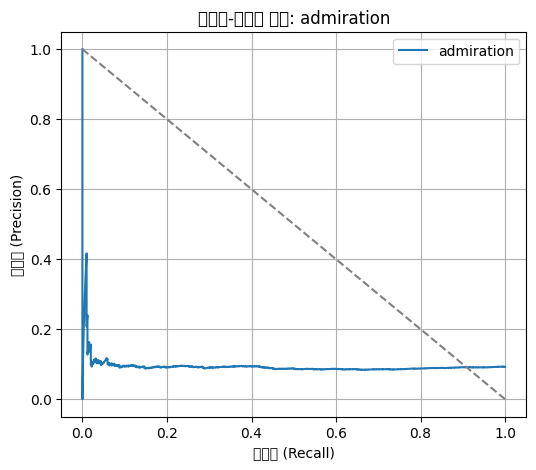

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

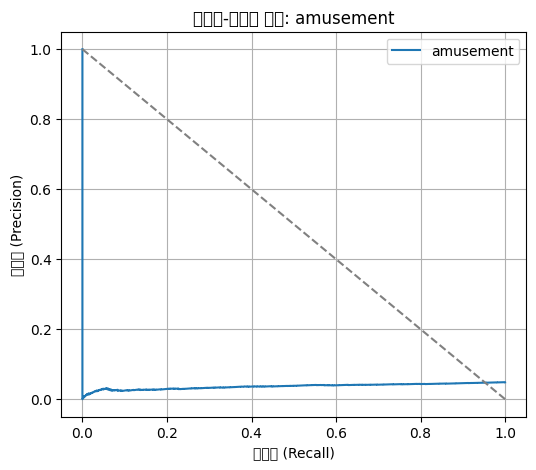

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

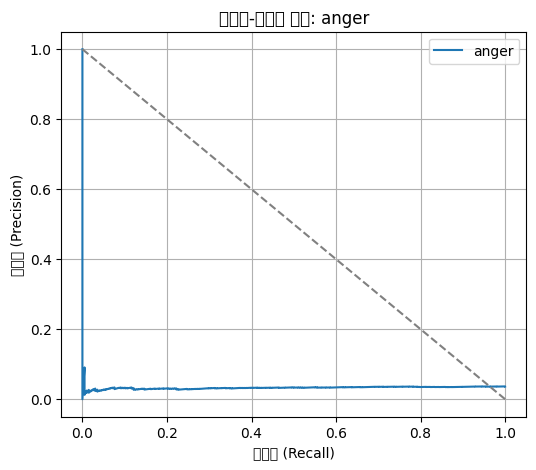

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

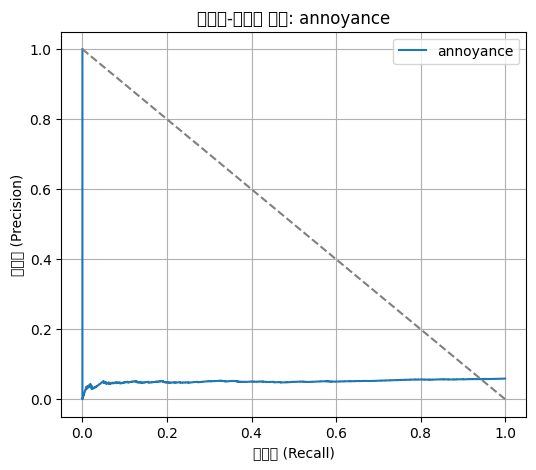

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

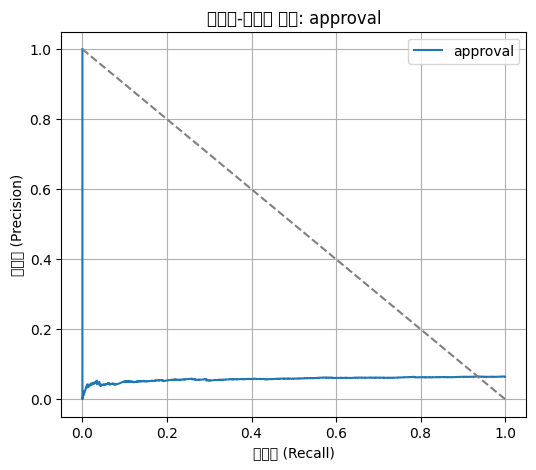

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

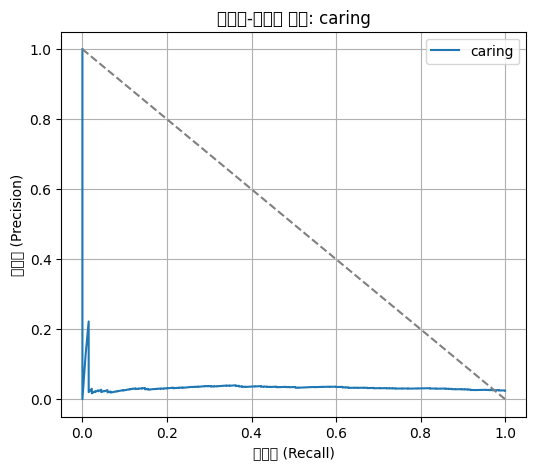

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

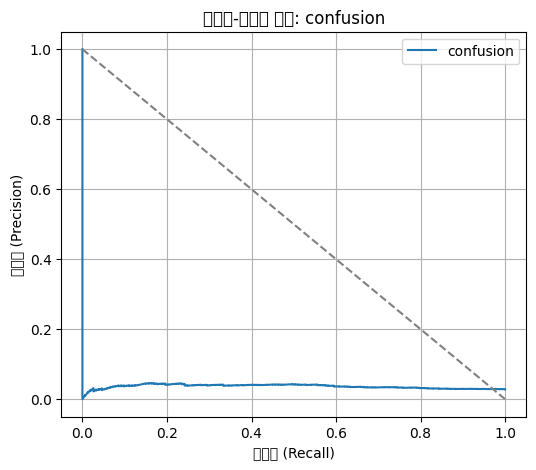

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

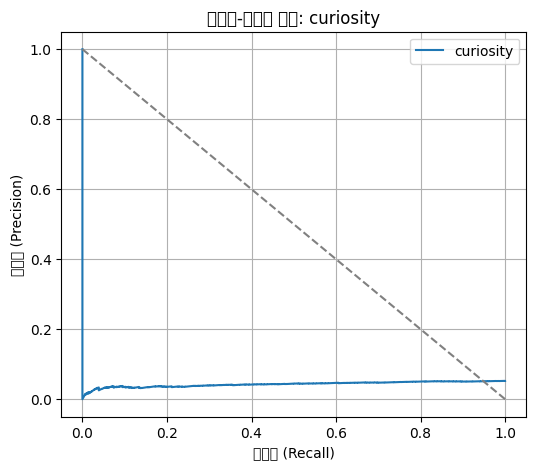

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

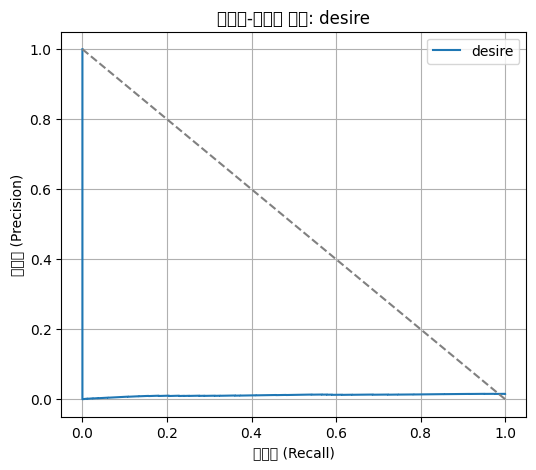

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

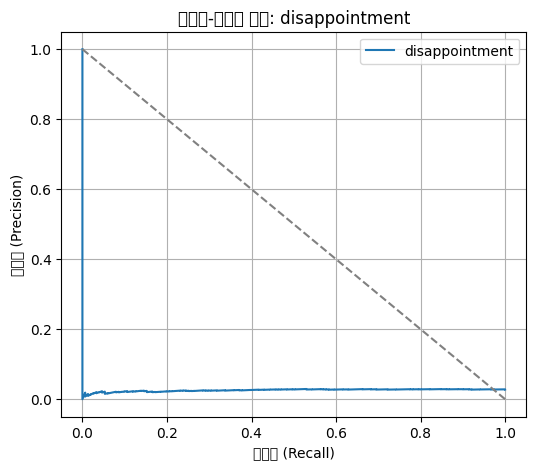

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

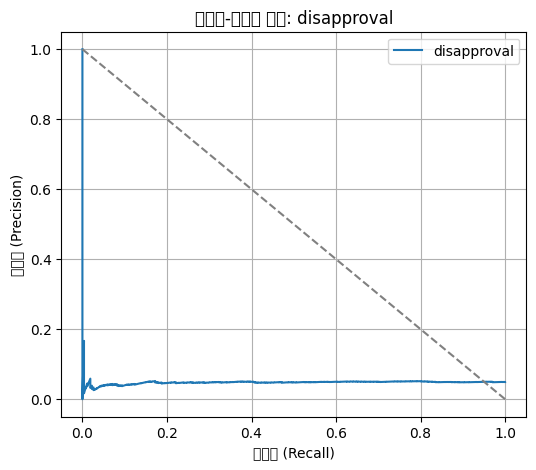

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

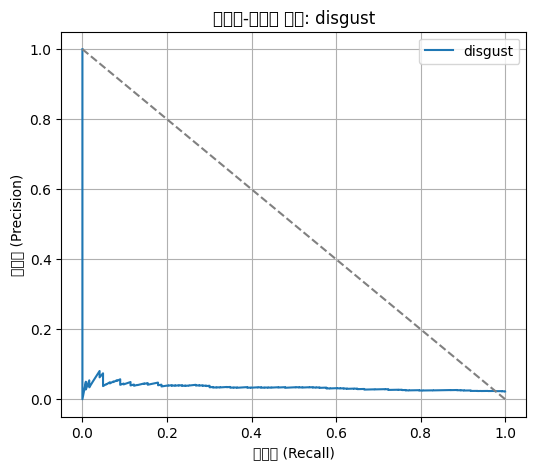

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

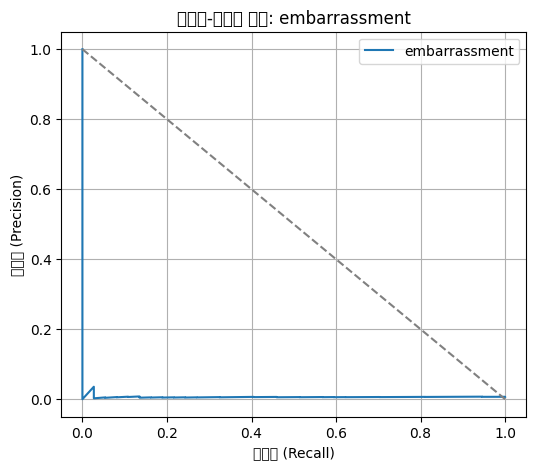

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

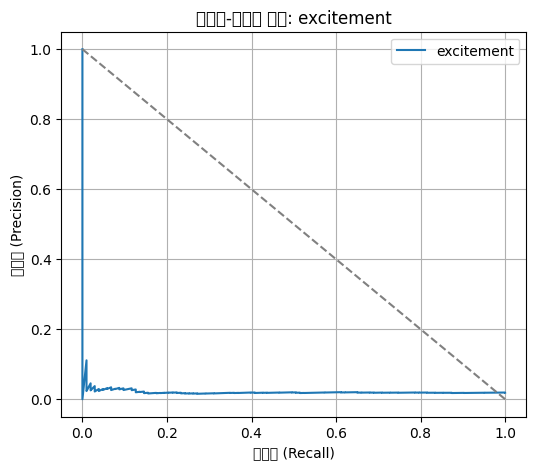

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

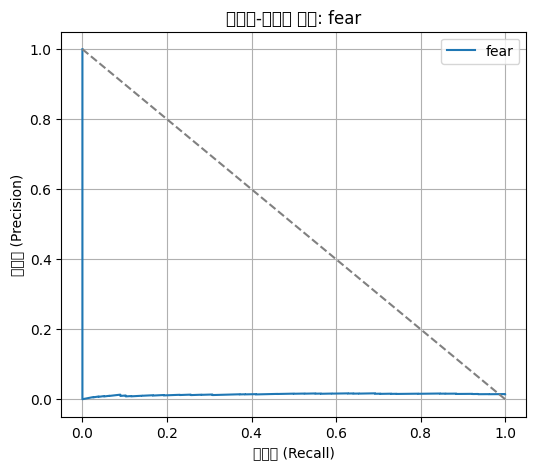

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

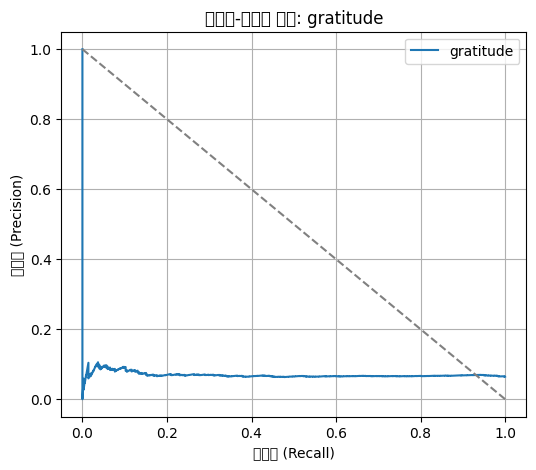

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

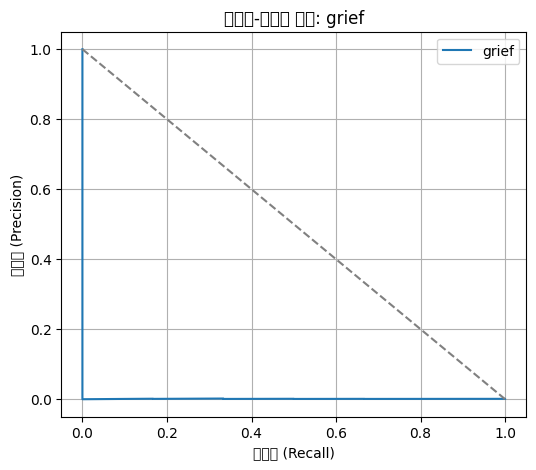

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

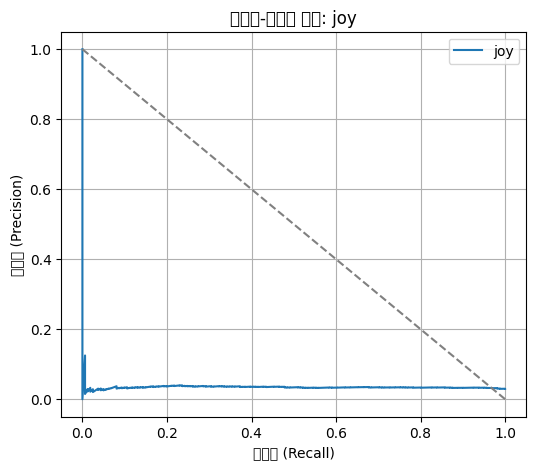

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

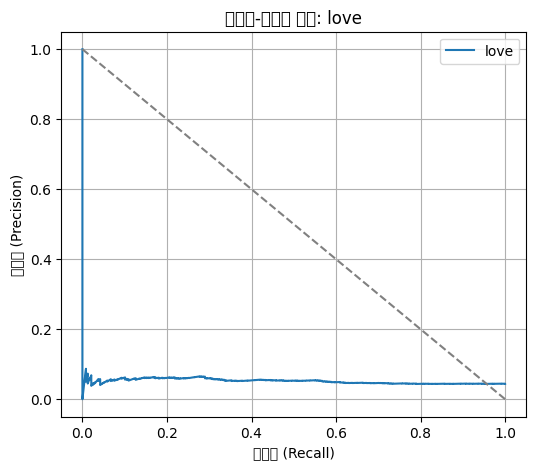

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

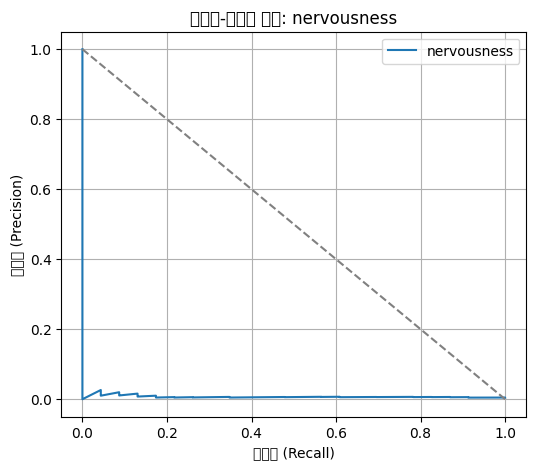

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

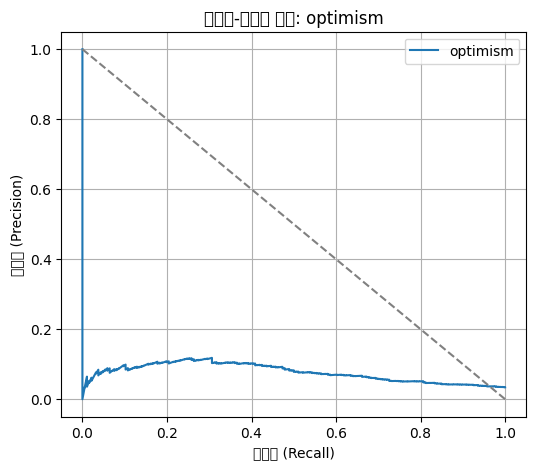

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

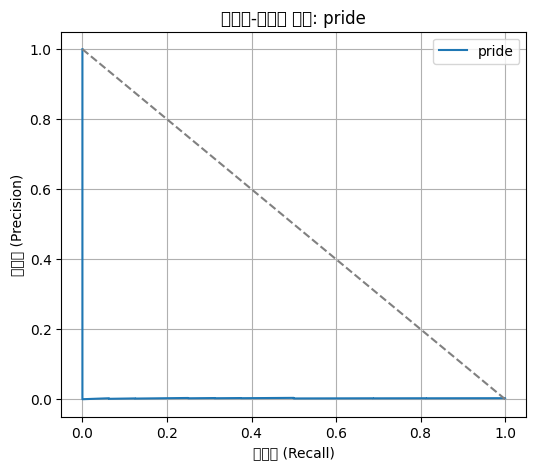

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

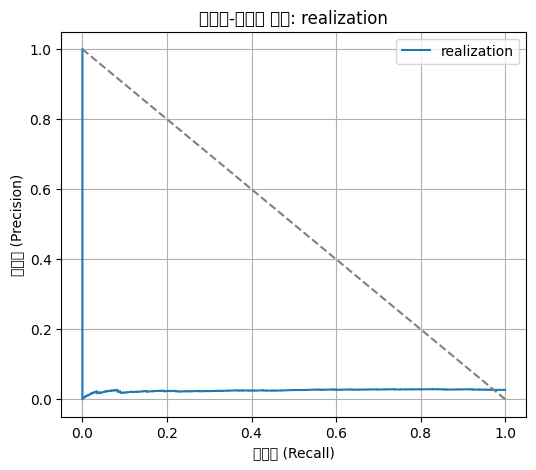

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

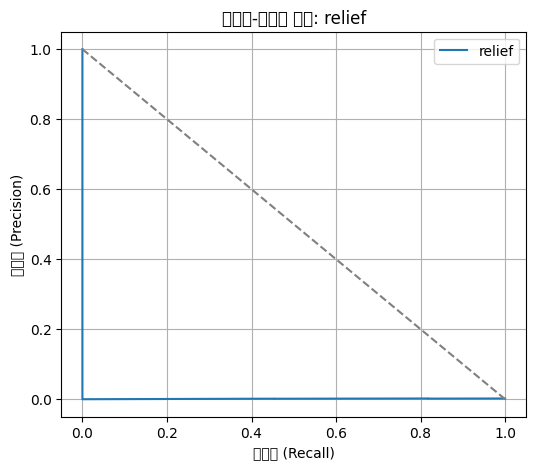

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

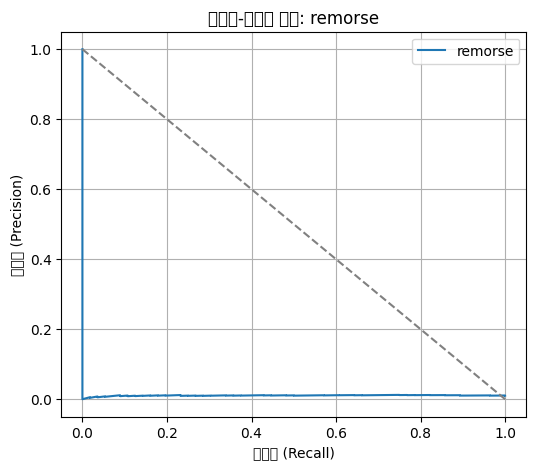

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

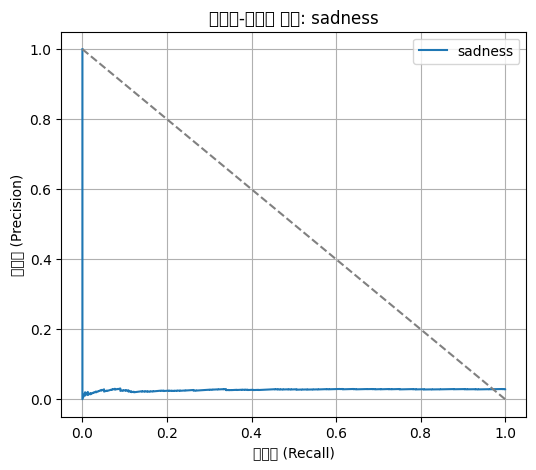

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

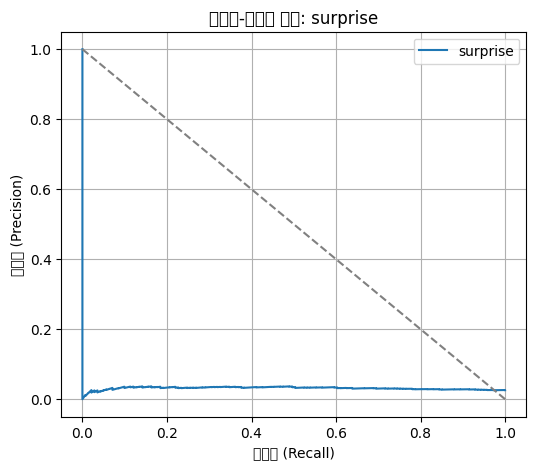

c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\biz\anaconda3\envs\goemotions\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE H

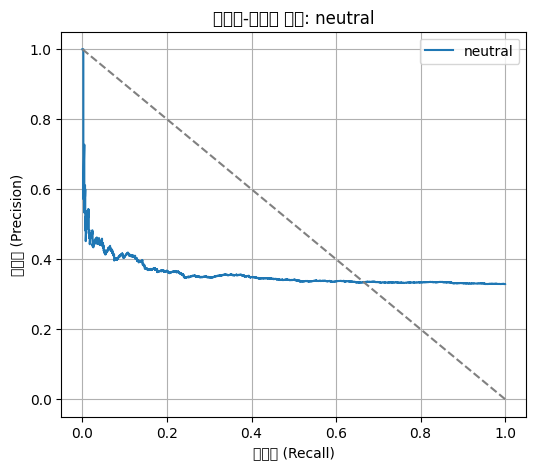

In [8]:
accuracy, f1_micro, f1_macro = evaluate_model(model, test_loader, device)

In [9]:
print(accuracy)

0.0
